In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import os
import intake
from datetime import datetime,timedelta
from matplotlib import rcParams
import matplotlib.patches as mpatches
from analysisFuncs import (applyFunc,plot_map,getRegion,regions,
ens_list,templates,gcm_yr_list,var_name,loca_ens,getStats)
import dask
dask.config.set({"array.slicing.split_large_chunks": True})
from glob import glob
from dask_jobqueue import PBSCluster
import dask
from dask.distributed import Client
import matplotlib.gridspec as gridspec

cluster = PBSCluster(
    queue="casper",
    walltime="3:00:00",
    project="P48500028",
    memory="10GB",
    cores=1,
    processes=1,
)

cluster.scale(10)


/glade/work/shartke/conda-envs/samEnv/lib/python3.7/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


SEAT
DENV
NYNY
NOLA


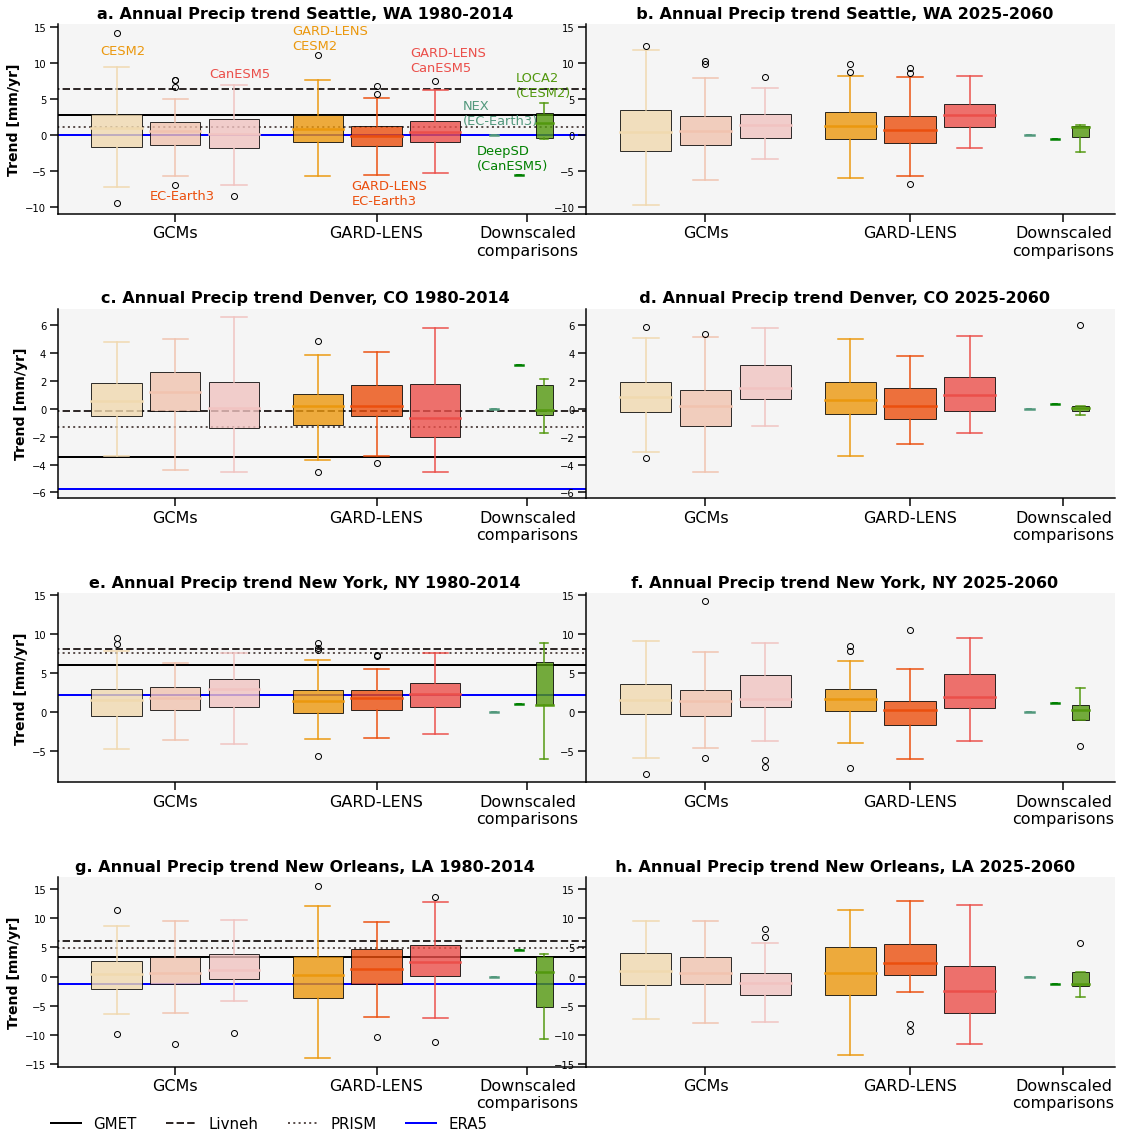

In [2]:

var='pcp'

runtag = ''
func = 'sum'
period = ('1980','2014')

# --- Read in observation datasets ----------------------
obs = {}

obs['gmet'] = xr.open_dataset('/glade/campaign/ral/hap/hartke/stat_files/GMET_stats_CONUS.nc')['%s_%s'%(var,func)]

files = []
for y in np.arange(1980,2015): files.append(templates['Livneh'].format(yr=y))
obs['Livneh'] = xr.open_mfdataset(files,concat_dim='Time',combine='nested').rename({'Time':'time'})

files = glob(templates['PRISM'].format(yr='*',var=var_name[var]['PRISM'],var2=var_name[var]['PRISM2']))
obs['PRISM'] = xr.open_mfdataset(np.sort(files),concat_dim='time',combine='nested').drop(('lat','lon'))

# --- Read in reanalysis (ERA5) datasets
files = []
for y in np.arange(1980,2017): files.append(templates['ERA5'].format(yr=y,runtag=''))
era5 = xr.open_mfdataset(files,concat_dim='time',combine='nested')

# --- Open GCM stat data
gcms = {}
for gcm in ('cesmlens2','ecearth3','canesm5'):
    gcms[gcm] = xr.open_dataset('/glade/campaign/ral/hap/hartke/stat_files/%s_%s_stats_CONUS.nc'%(gcm,var))[func]


# --- Open LOCA2 data
loca_ds = xr.open_dataset('/glade/campaign/ral/hap/hartke/stat_files/LOCA2_%s_stats.nc'%var)[func]


# --- Open NEX-GDDP data
nex_files = glob(templates['NEX'].format(var='pr',scen='historical',gcm='CanESM5',ens='r1i1p1f1',yr="*",g='*'))
nex_stats = getRegion(xr.open_mfdataset(np.sort(nex_files),concat_dim='time',combine='nested'),regions['CONUS'])
nex_stats['lon'] = nex_stats['lon']-180.

nex_files = glob(templates['NEX'].format(var='pr',scen='ssp370',gcm='CanESM5',ens='r1i1p1f1',yr="*",g='*'))
nex_stats2 = getRegion(xr.open_mfdataset(np.sort(nex_files),concat_dim='time',combine='nested'),regions['CONUS'])
nex_stats2['lon'] = nex_stats2['lon']-180.


loc_longnames = {'SEAT':'Seattle, WA',
                'DENV':'Denver, CO',
                'NYNY':'New York, NY',
                'NOLA':'New Orleans, LA'}

letters = ('a.','b.','c.','d.','e.','f.','g.','h.')

fig = plt.figure(figsize=(16,16))
gs = gridspec.GridSpec(4, 2,width_ratios=[4,4])

i=1
for loc in ('SEAT','DENV','NYNY','NOLA'):

    print(loc)
    
    r = regions[loc]
    
    res1 = {}
    res = {}
    
    obs2 = getRegion(obs['gmet'],r,time=period,time_var='year')
    res1['GMET'] = applyFunc(obs2,func='trend').load()
    
    obs2 = getRegion(obs['Livneh'],r,time=period)[var_name[var]['Livneh']]
    res1['Livneh'] = applyFunc(applyFunc(obs2,func),'trend').load()
    
    obs2 = getRegion(obs['PRISM'],r,latname='rlat',lonname='rlon',time=period)[var_name[var]['PRISM']]
    res1['PRISM'] = applyFunc(applyFunc(obs2,func),'trend').load()
    
    era2 = getRegion(era5,r,latname='latitude',lonname='longitude',time=period)[var_name[var]['ERA5']]
    res1['ERA5'] = applyFunc(applyFunc(era2,func),'trend').load()
    
    for gcm in ('cesmlens2','ecearth3','canesm5'):
        gcm_ens = getRegion(gcms[gcm],r,time=period,time_var='year')
        if len(r)>2: gcm_ens = gcm_ens.mean(('lat','lon'))
        res[gcm] = applyFunc(gcm_ens,'trend')
    
    ds = xr.open_dataset('/glade/campaign/ral/hap/hartke/stat_files/GARDLENS_%s_stats_CONUS.nc'%var)[func]
    for gcm in ('cesmlens2','ecearth3','canesm5'):
        res['GARD%s'%gcm] = applyFunc(getRegion(ds.sel(n_ens=ds.gcm==gcm),r,time=(period[0],period[1]),time_var='year'),'trend')

    deepsd = getRegion(xr.open_dataset('/glade/campaign/ral/hap/hartke/stat_files/DeepSD_%s_stats.nc'%var)[func],r,time=period,time_var='year').load()
    if int(period[1])<2015:
        deepsd = deepsd.sel(n_ens=deepsd['scen']=='historical')
    if int(period[0])>=2015:
        deepsd = deepsd.sel(n_ens=deepsd['scen']=='ssp370')
    res['DeepSD'] = applyFunc(deepsd.sel(n_ens=deepsd['gcm']=='canesm5'),'trend').values

    
    loca = getRegion(loca_ds.sel(n_ens=loca_ds['gcm']=='cesmlens2'),r,time=period,time_var='year').load() 
    loca = loca.sel(n_ens=loca['scen']=='historical')
    res['LOCA'] = applyFunc(loca,'trend')
    
    nex = getRegion(nex_stats,r,time=period).pr
    ds_trend = applyFunc(applyFunc(nex,func),'trend')
    res['NEX'] = ds_trend.values
    
        
    if i==1:
        #ax2 = fig.add_subplot(4,2,i)
        ax2 = plt.subplot(gs[i-1,0])
    else:
        share_ax = ax2
        #ax2 = fig.add_subplot(4,2,i,sharex = share_ax)
        ax2 = plt.subplot(gs[i-1,0],sharex = share_ax)

    ax2.plot((-1,6),(res1['GMET'],res1['GMET']),c='k',label='GMET')
    ax2.plot((-1,6),(res1['Livneh'],res1['Livneh']),c='#302A29',label='Livneh',linestyle='dashed')
    ax2.plot((-1,6),(res1['PRISM'],res1['PRISM']),c='#5C504E',label='PRISM',linestyle='dotted')
    ax2.plot((-1,6),(res1['ERA5'],res1['ERA5']),c='b',label='ERA5')
    
    labels, data = res.keys(), res.values()
    # bp = ax2.boxplot(data, positions=[2.1,2.2,2.,2.3,2.65,3.0,3.35,3.85,4.2,4.55,5.05,5.2,4.9],
    #                  widths = (15.05,15.05,15.05,15.05,0.3,0.3,0.3,0.3,0.3,0.3,0.05,0.1,.05), patch_artist=True)
    bp = ax2.boxplot(data, positions=[2.65,3.0,3.35,3.85,4.2,4.55,5.05,5.2,4.9],
                     widths = (0.3,0.3,0.3,0.3,0.3,0.3,0.05,0.1,.05), patch_artist=True)
    
    # changing color and linewidth of boxplot data
    #colors = ('k','#302A29','#5C504E','b','#EB980E','#EB4F0E','#EB4F4A','#EB980E','#EB4F0E','#EB4F4A','g','#52980E','#52987C','#9DB30E')
    colors = ('#F0D9AF','#F1C3AF','#F1C3C1','#EB980E','#EB4F0E','#EB4F4A','g','#52980E','#52987C','#9DB30E')
    
    n_dsets = len(bp['medians'])
    for j in range(n_dsets):
        bp['whiskers'][2*j].set(color =colors[j],linewidth = 1.5)
        bp['whiskers'][2*j+1].set(color =colors[j],linewidth = 1.5)
        bp['caps'][2*j].set(color =colors[j],linewidth = 1.5)
        bp['caps'][2*j+1].set(color =colors[j],linewidth = 1.5)
        bp['medians'][j].set(color =colors[j],linewidth = 2.5)
        bp['fliers'][j].set(color =colors[j],linewidth = 1.5)
    
    j=0
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(colors[j])
        patch.set_alpha(0.8)
        j+=1

    if i==1:
        # ax2.annotate('GMET',xy=(2.,res['GMET']+0.8),fontsize=13,color='k')
        # ax2.annotate('Livneh',xy=(2.1,res['Livneh']+0.8),fontsize=13,color=colors[1])
        # ax2.annotate('PRISM',xy=(1.9,res['PRISM']-2.),fontsize=13,color=colors[2])
        # ax2.annotate('ERA5',xy=(2.2,res['ERA5']-2.),fontsize=13,color='b')
        
        ax2.annotate('CESM2',xy=(2.55,np.max(res['cesmlens2'])-3.),fontsize=13,color=colors[3])
        ax2.annotate('EC-Earth3',xy=(2.85,np.min(res['ecearth3'])-2.),fontsize=13,color=colors[4])
        ax2.annotate('CanESM5',xy=(3.2,np.max(res['canesm5'])+1.),fontsize=13,color=colors[5])
        
        ax2.annotate('GARD-LENS\nCESM2',xy=(3.7,np.max(res['GARDcesmlens2'])+0.8),fontsize=13,color=colors[3])
        ax2.annotate('GARD-LENS\nEC-Earth3',xy=(4.05,np.min(res['GARDecearth3'])-4.),fontsize=13,color=colors[4])
        ax2.annotate('GARD-LENS\nCanESM5',xy=(4.4,np.max(res['GARDcanesm5'])+1.5),fontsize=13,color=colors[5])
        
        ax2.annotate('DeepSD\n(CanESM5)',xy=(4.8,res['DeepSD']+0.8),fontsize=13,color=colors[6])
        ax2.annotate('LOCA2\n(CESM2)',xy=(5.03,np.max(res['LOCA'])+.9),fontsize=13,color=colors[7])
        ax2.annotate('NEX\n(EC-Earth3)',xy=(4.712,res['NEX']+1.5),fontsize=13,color=colors[8])
        
        # ax2.annotate('STAR (CanESM5-r1i1p1f1)',xy=(4.8,res['STAR']+0.3),fontsize=13,color=colors[13])
        
    
    labels = ('Obs &\nReanalysis','GCMs','GARD-LENS','Downscaled\ncomparisons')
    ax2.set_xticks((2.1,3.,4.2,5.1))
    ax2.set_xticklabels(labels,fontsize=16)
    #ax2.set_ylim((-16,20))
    ax2.set_xlim((2.3,5.45))
    ax2.set_title('%s Annual Precip trend %s 1980-2014      '%(letters[2*i-2],loc_longnames[loc]),fontsize=16)
    ax2.spines[['right', 'top']].set_visible(False)
    
    if var=='pcp': ax2.set_ylabel('Trend [mm/yr]',fontsize=14)
    elif var=='t_mean': ax2.set_ylabel('Trend [C/yr]',fontsize=14)


    res = {}

    for gcm in ('cesmlens2','ecearth3','canesm5'):
        gcm_ens = getRegion(gcms[gcm],r,time=('2025','2060'),time_var='year')
        if len(r)>2: gcm_ens = gcm_ens.mean(('lat','lon'))
        res[gcm] = applyFunc(gcm_ens,'trend')
    
    ds = xr.open_dataset('/glade/campaign/ral/hap/hartke/stat_files/GARDLENS_%s_stats_CONUS.nc'%var)[func]
    for gcm in ('cesmlens2','ecearth3','canesm5'):
        res['GARD%s'%gcm] = applyFunc(getRegion(ds.sel(n_ens=ds.gcm==gcm),r,time=('2025','2060'),time_var='year'),'trend')

    deepsd = getRegion(xr.open_dataset('/glade/campaign/ral/hap/hartke/stat_files/DeepSD_%s_stats.nc'%var)[func],r,time=('2025','2060'),time_var='year').load()
    deepsd = deepsd.sel(n_ens=deepsd['scen']=='ssp370')
    res['DeepSD'] = applyFunc(deepsd.sel(n_ens=deepsd['gcm']=='canesm5'),'trend').values

    loca = getRegion(loca_ds.sel(n_ens=loca_ds['gcm']=='cesmlens2'),r,time=('2025','2060'),time_var='year').load() 
    loca = loca.sel(n_ens=loca['scen']=='ssp370')
    res['LOCA'] = applyFunc(loca,'trend')
    
    nex = getRegion(nex_stats2,r,time=('2025','2060')).pr
    ds_trend = applyFunc(applyFunc(nex,func),'trend')
    res['NEX'] = ds_trend.values
    
        
    #ax3 = fig.add_subplot(4,2,i+1,sharey=ax2)
    ax3 = plt.subplot(gs[i-1,1],sharey=ax2)
    labels, data = res.keys(), res.values()
    bp = ax3.boxplot(data, positions=[2.65,3.0,3.35,3.85,4.2,4.55,5.05,5.2,4.9],
                     widths = (0.3,0.3,0.3,0.3,0.3,0.3,0.05,0.1,.05), patch_artist=True)
    
    # changing color and linewidth of boxplot data
    colors = ('#F0D9AF','#F1C3AF','#F1C3C1','#EB980E','#EB4F0E','#EB4F4A','g','#52980E','#52987C','#9DB30E')
    
    n_dsets = len(bp['medians'])
    for j in range(n_dsets):
        bp['whiskers'][2*j].set(color =colors[j],linewidth = 1.5)
        bp['whiskers'][2*j+1].set(color =colors[j],linewidth = 1.5)
        bp['caps'][2*j].set(color =colors[j],linewidth = 1.5)
        bp['caps'][2*j+1].set(color =colors[j],linewidth = 1.5)
        bp['medians'][j].set(color =colors[j],linewidth = 2.5)
        bp['fliers'][j].set(color =colors[j],linewidth = 1.5)
    
    j=0
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(colors[j])
        patch.set_alpha(0.8)
        j+=1

    labels = ('GCMs','GARD-LENS','Downscaled\ncomparisons')
    ax3.set_xticks((3.,4.2,5.1))
    ax3.set_xticklabels(labels,fontsize=16)
    #ax3.set_ylim((-16,20))
    ax3.set_xlim((2.3,5.4))
    ax3.set_title('  %s Annual Precip trend %s 2025-2060    '%(letters[2*i-1],loc_longnames[loc]),fontsize=16)
    ax3.spines[['right', 'top']].set_visible(False)
    #ax3.set_yticks([])
    #ax3.set_yticklabels([]) 
    
    i+=1

ax2.legend(fontsize=15,loc=8,bbox_to_anchor=(0.4, -0.41),ncol=4)

plt.tight_layout()
plt.subplots_adjust(wspace=0.,hspace=0.5)
fig.savefig('figures/PaperFigure4_trends_%s_%s_boxplot.jpg'%(var,func),dpi=1200)
plt.show()

